In [ ]:
# 产量数据，产品质量

### 生成每月生产计划

In [2]:
from imports import *

In [89]:
!pip install nbformat==4.2.0

In [3]:
df_order_monthly = pd.read_csv(os.path.join(GE_DIR, 'order_monthly.csv'))

In [38]:
# ----- To-Do 设置整数
import pandas as pd

# 构建order表的示例数据
order = df_order_monthly

# 构建plan表的空DataFrame
plan = pd.DataFrame(columns=['month', 'product_name', 'count_raw', 'production', 'inventory'])

# 根据不同的产品分别构建生产计划
for product_name in order['product_name'].unique():
    # 筛选出当前产品的需求数据
    product_order = order[order['product_name'] == product_name].reset_index(drop=True)
    
    # 设置初始的生产计划和库存
    production = 1000
    inventory = int(production - product_order.iloc[0]['count_raw'])

    # 构建第一个月的计划
    plan.loc[len(plan)] = [product_order.iloc[0]['month'], product_name, product_order.iloc[0]['count_raw'], production, inventory]

    # 根据当前产品的需求数据动态构建生产计划
    for i in range(1, len(product_order)):
        # 根据上个月的inventory和production计算该月的inventory和production
        last_month_inventory = plan[plan['product_name'] == product_name].iloc[i-1]['inventory']
        last_month_production = plan[plan['product_name'] == product_name].iloc[i-1]['production']
        last_month_demand = product_order.iloc[i-1]['count_raw']
        demand = product_order.iloc[i]['count_raw']

        # To-Do Max Inv 根据过去平均销量的一半，如果超过当前Max Inv，就用平均销量的一半作为新的Max Inv

        # 根据inventory调整该月的production
        if last_month_inventory < 0:
            production = int(max(last_month_demand * 1.2, 0))
        elif last_month_inventory > 3000:
            production = int(max(last_month_demand * 0.8, 0)) - last_month_inventory * 0.5 # To-Do 再加上未来三个月的需求 
        else:
            production = last_month_production

        inventory = last_month_inventory + production - demand

        # 更新计划表
        plan.loc[len(plan)] = [product_order.iloc[i]['month'], product_name, product_order.iloc[i]['count_raw'], max(production, 0), inventory]

# 打印结果
print(plan)


          month product_name  count_raw   production    inventory
0    2018-01-01          基础款       1057   1000.00000    -57.00000
1    2018-02-01          基础款        997   1268.00000    214.00000
2    2018-03-01          基础款       1219   1268.00000    263.00000
3    2018-04-01          基础款       1029   1268.00000    502.00000
4    2018-05-01          基础款       1783   1268.00000    -13.00000
5    2018-06-01          基础款       1262   2139.00000    864.00000
6    2018-07-01          基础款       1918   2139.00000   1085.00000
7    2018-08-01          基础款        890   2139.00000   2334.00000
8    2018-09-01          基础款       1984   2139.00000   2489.00000
9    2018-10-01          基础款       2427   2139.00000   2201.00000
10   2018-11-01          基础款       2936   2139.00000   1404.00000
11   2018-12-01          基础款       2763   2139.00000    780.00000
12   2019-01-01          基础款       3379   2139.00000   -460.00000
13   2019-02-01          基础款       3139   4054.00000    455.00000
14   2019-

In [86]:
import pandas as pd
import numpy as np

# 构建order表的示例数据
order = df_order_monthly

# 构建plan表的空DataFrame
plan = pd.DataFrame(columns=['month', 'product_name', 'count_raw','Max_Inv','production', 'inventory'])

# 根据不同的产品分别构建生产计划
for product_name in order['product_name'].unique():
    # 筛选出当前产品的需求数据
    product_order = order[order['product_name'] == product_name].reset_index(drop=True)
    
    # 设置初始的生产计划和库存
    production = 1000
    inventory = int(production - product_order.iloc[0]['count_raw'])
    
    # 初始Max_Inv值为3000
    Max_Inv = 3000
    # 过去三个月的销量数据
    past_demand = np.zeros(3)
    # 当前所用的past_demand数据索引
    past_demand_idx = 0

    # 构建第一个月的计划
    plan.loc[len(plan)] = [product_order.iloc[0]['month'], product_name, product_order.iloc[0]['count_raw'], Max_Inv,production, inventory]

    # 根据当前产品的需求数据动态构建生产计划
    for i in range(1, len(product_order)):
        # 根据上个月的inventory和production计算该月的inventory和production
        last_month_inventory = plan[plan['product_name'] == product_name].iloc[i-1]['inventory']
        last_month_production = plan[plan['product_name'] == product_name].iloc[i-1]['production']
        last_month_demand = product_order.iloc[i-1]['count_raw']
        demand = product_order.iloc[i]['count_raw']
        
        # 计算过去三个月平均销量
        past_demand[past_demand_idx] = last_month_demand
        past_demand_idx = (past_demand_idx + 1) % 3
        avg_demand = int(np.mean(past_demand) / 2) 
        # 如果当前inventory超过了Max_Inv，则更新Max_Inv
        if avg_demand > Max_Inv:
            Max_Inv = avg_demand
        
        # 根据inventory调整该月的production
        try:
            if last_month_inventory < 0:
                production = int(max(last_month_demand * 1.2, 0))
            elif last_month_inventory > Max_Inv:
                production = int(max(last_month_demand, 0)) - int(last_month_inventory) + product_order.iloc[i+1]['count_raw']/2  # To-Do 再加上未来三个月的平均需求 
            else:
                production = last_month_production
        except:
            production = last_month_production

        inventory = last_month_inventory + production - demand

        # 更新计划表
        plan.loc[len(plan)] = [product_order.iloc[i]['month'], product_name, product_order.iloc[i]['count_raw'], Max_Inv, max(production, 0), inventory]

# 打印
print(plan)


          month product_name  count_raw  Max_Inv  production  inventory
0    2018-01-01          基础款       1057     3000      1000.0      -57.0
1    2018-02-01          基础款        997     3000      1268.0      214.0
2    2018-03-01          基础款       1219     3000      1268.0      263.0
3    2018-04-01          基础款       1029     3000      1268.0      502.0
4    2018-05-01          基础款       1783     3000      1268.0      -13.0
5    2018-06-01          基础款       1262     3000      2139.0      864.0
6    2018-07-01          基础款       1918     3000      2139.0     1085.0
7    2018-08-01          基础款        890     3000      2139.0     2334.0
8    2018-09-01          基础款       1984     3000      2139.0     2489.0
9    2018-10-01          基础款       2427     3000      2139.0     2201.0
10   2018-11-01          基础款       2936     3000      2139.0     1404.0
11   2018-12-01          基础款       2763     3000      2139.0      780.0
12   2019-01-01          基础款       3379     3000      2139.0    

In [87]:
plan

,month,product_name,count_raw,Max_Inv,production,inventory
0,2018-01-01,基础款,1057,3000,1000.0,-57.0
1,2018-02-01,基础款,997,3000,1268.0,214.0
2,2018-03-01,基础款,1219,3000,1268.0,263.0
3,2018-04-01,基础款,1029,3000,1268.0,502.0
4,2018-05-01,基础款,1783,3000,1268.0,-13.0
5,2018-06-01,基础款,1262,3000,2139.0,864.0
6,2018-07-01,基础款,1918,3000,2139.0,1085.0
7,2018-08-01,基础款,890,3000,2139.0,2334.0
8,2018-09-01,基础款,1984,3000,2139.0,2489.0
9,2018-10-01,基础款,2427,3000,2139.0,2201.0


In [88]:
import plotly.express as px

fig = px.line(plan, x='month', y='count_raw', color='product_name')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

AttributeError: module 'matplotlib.pyplot' has no attribute 'Color'

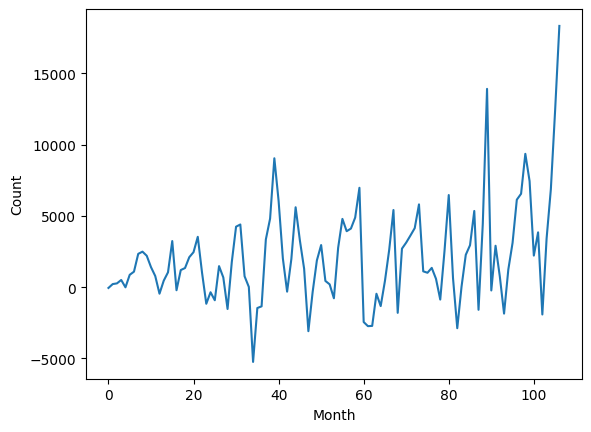

In [78]:
import matplotlib.pyplot as plt

# 获取需要绘制折线图的数据
x = range(len(plan))
y1 = plan['inventory']

# 创建并显示折线图
plt.plot(x, y1, label='inventory')
plt.xlabel('Month')
plt.ylabel('Count')
plt.Color('product_name')
plt.legend()
plt.show()

In [6]:
# 新建df_production
df_production = pd.DataFrame(columns=['product_id','month', 'production'])

for i in range(len(df_order_monthly) - 1):
    # 获取当月的月份和下个月的订单数量
    product_id = df_order_monthly.loc[i+1, 'product_id']
    month = df_order_monthly.loc[i, 'month']
    production = df_order_monthly.loc[i+1, 'count_raw']

    df_production.loc[i] = [product_id, month, production]

In [7]:
df_production

,product_id,month,production
0,1,2018-01-01,997
1,1,2018-02-01,1219
2,1,2018-03-01,1029
3,1,2018-04-01,1783
4,1,2018-05-01,1262
...,...,...,...
138,4,2022-07-01,3418
139,4,2022-08-01,3460
140,4,2022-09-01,4003
141,4,2022-10-01,2870


### 计算产线通过率

In [8]:
df_equipment = pd.read_csv(os.path.join(BASE_DIR, 'equipment.csv'))

In [14]:
# 按line分组，并计算每个组的通过率
pass_rates = df_equipment.groupby('line')['equipment_pass_rate'].prod()

# 创建一个新的DataFrame来保存产线通过率
df_pass_rates = pd.DataFrame({
    'line': pass_rates.index,
    'pass_rate': pass_rates.values
})

# 输出结果
print(df_pass_rates)

   line  pass_rate
0     1       0.95
1     2       0.95


### 生成order序列号

In [2]:
import datetime
import pandas as pd
import pymysql

In [6]:
df_order_detail = pd.read_csv(os.path.join(GE_DIR, 'order_detail.csv'))

In [10]:

def generate_serial_number(row, id_col, date_col, time_col):
    # 获取订单日期和时间的格式化字符串
    order_date = datetime.strptime(row[date_col], "%Y-%m-%d").date()
    order_time = datetime.strptime(row[time_col], "%H:%M").time()
    date_str = order_date.strftime("%y%m%d")
    time_str = order_time.strftime("%H%M")
    
    # 生成序列号
    serial_number = f"{date_str}{time_str}{row[id_col]:06d}"
    return serial_number


# 生成序列号
df_order_detail["serial_number"] = df_order_detail.apply(
    generate_serial_number,
    axis=1,
    args=(
        "id",  # id列名
        "date",  # date列名
        "time",  # time列名
    )
)



In [11]:
df_order_detail

,id,date,time,datetime,provice,city,serial_number
0,0,2022-12-01,22:45,2022-12-01 22:45,北京,北京市,2212012245000000
1,1,2022-12-01,13:47,2022-12-01 13:47,江苏,苏州市,2212011347000001
2,2,2022-12-01,10:39,2022-12-01 10:39,江苏,扬州市,2212011039000002
3,3,2022-12-01,10:40,2022-12-01 10:40,江苏,淮安市(原淮阴市）,2212011040000003
4,4,2022-12-01,15:43,2022-12-01 15:43,上海,上海市,2212011543000004
...,...,...,...,...,...,...,...
3539,106,2022-12-31,09:44,2022-12-31 09:44,上海,上海市,2212310944000106
3540,107,2022-12-31,13:49,2022-12-31 13:49,上海,上海市,2212311349000107
3541,108,2022-12-31,14:35,2022-12-31 14:35,江苏,泰州市,2212311435000108
3542,109,2022-12-31,08:04,2022-12-31 08:04,浙江,温州市,2212310804000109


In [ ]:
# 按照生产产品建立production serial num，通过不同工站，产品每天生产，生成随机时间。生成每一行是零件，纵向是工站，时间和结果。实际的cycle time和计算良率。
# 生产时间，库存时间，交付时间。